In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import time


def logistic_sigmoid(a):
    return 1 / (1 + np.exp(-a))

def rand_gauss(n, mu, cov):
    if cov.ndim == 1:
        cov = np.diag(cov)
    assert(mu.ndim == 1 and len(mu) == len(cov) and cov.ndim == 2 and cov.shape[0] == cov.shape[1])
    d, v = np.linalg.eigh(cov)
    return (np.random.randn(n, len(mu)) * np.sqrt(d)).dot(v) + mu

def logpdf_gauss(x, mu, cov):
    assert(mu.ndim == 1 and len(mu) == len(cov) and (cov.ndim == 1 or cov.shape[0] == cov.shape[1]))
    x = np.atleast_2d(x) - mu
    return -0.5*(len(mu)*np.log(2 * np.pi) + np.linalg.slogdet(cov)[1] + np.sum(x.dot(np.linalg.inv(cov)) * x, axis=1))
      
def plot2dfun(f, limits, resolution, ax=None):
    if ax is None:
        ax = plt
    xmin, xmax, ymin, ymax = limits
    xlim = np.arange(ymin, ymax, (ymax - ymin) / float(resolution))
    ylim = np.arange(xmin, xmax, (xmax - xmin) / float(resolution))
    a, b = np.meshgrid(ylim, xlim)
    img = f(np.vstack([np.ravel(a), np.ravel(b)[::-1]]).T)
    img = (img - img.min()) /(img.max() - img.min()) # normalize to range 0.0 - 1.0
    img = img.reshape(a.shape+img.shape[1:])
    ax.imshow(img, cmap='gray', aspect='auto', extent=(xmin, xmax, ymin, ymax))
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)

# Perceptron

$$y(\mathbf{x})=f(\mathbf{w}^T \mathbf{x})$$
where
$$f(a)=
\begin{cases}
    +1,& a\geq 0\\
    -1,& a < 0
\end{cases}$$

PĹi trĂŠnovĂĄnĂ­ prochĂĄzĂ­me trĂŠnovacĂ­ vzory (napĹ. cyklicky) a kdykoli najdeme ĹĄpatnÄ klasifikovanĂ˝ vzor kde $y(\mathbf{x}_n )\ne t_n $, provedeme Ăşpravu paramerĹŻ:

$$\mathbf{w}^{\tau+1}=\mathbf{w}^\tau+\mathbf{x}_n t_n$$

kde $\mathbf{x}_n$ je trĂŠnovacĂ­ vzor a $t_n \in \{-1,1\}$ je odpovĂ­dajĂ­cĂ­ anotace. 


In [ ]:
red_data  = np.array([[0.2, 0.4, 0.5, 0.7, 0.9], [0.7, -0.5, 0.3, -0.9, 0.9]]).T
blue_data = np.array([[-0.1, -0.4, -0.5, -0.6, -0.7], [-0.2, 0.7, 0.6, 0.9, 0.5]]).T

plt.plot(red_data[:,0], red_data[:,1], 'r.')
plt.plot(blue_data[:,0], blue_data[:,1], 'b.')
plt.axis([-1, 1, -1, 1])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

data = np.r_[red_data, blue_data]
labs = np.r_[np.ones(len(red_data)), -np.ones(len(blue_data))]

#Inicializace parametru
w = np.array([-0.1867, -0.7258])

In [ ]:
#OpakovanÄ zpostejte tuto buĹku pro jednotlive iterace trĂŠnovĂĄnĂ­

#VykreslenĂ­ rozhodovaci hranice. V naĹĄem pĹĂ­padÄ nemĂĄme parametr w_0, takĹže rozhodovacĂ­ hranice musĂ­ prochĂĄzet poÄatkem
plt.cla()
plt.plot(red_data[:,0],  red_data[:,1], 'r.', blue_data[:,0], blue_data[:,1], 'b.')
plt.plot([0, w[0]], [0, w[1]], 'k')
plt.plot([-w[1] * 10, w[1] * 10], [w[0] * 10, -w[0] * 10], 'k')
plt.axis([-1, 1, -1, 1])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)


# Najdi ĹĄpatnÄ klasifikovanĂŠ trĂŠnovaci dato (zelenĂĄ teÄka) a proveÄ pro nej "update".
for x, t in zip(data, labs):
  if x.dot(w) * t < 0:
    plt.plot(x[0], x[1], 'go', ms=12, lw=2)
    plt.show()
    w = w + x*t
    break

# LinearnĂ­ gaussovskĂ˝ klasifikĂĄtor pro 2 tĹĂ­dy

$$\begin{align}
P(C_1|\mathbf{w}) &= \sigma(\mathbf{x}^T\mathbf{w} + w_0)\\
\mathbf{w} &= \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu}_1-\boldsymbol{\mu}_2)\\
w_0 &= -\frac{1}{2}\boldsymbol{\mu}_1^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_1
       +\frac{1}{2}\boldsymbol{\mu}_2^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_2
       +\ln\frac{P(C_1)}{P(C_2)}\\
\end{align}$$
kde maximalnÄ vÄrohodnĂ˝ odhad paramerĹŻ $\boldsymbol{\mu}_k$ je prostĂ˝ prĹŻmÄr dat pro tĹĂ­du $k$ a pro sdĂ­lenou kovarianÄnĂ­ matici $\hat{\boldsymbol{\Sigma}}$ je to
$$%\hat{\boldsymbol{\Sigma}} = \frac{1}{N}\sum_{k=1}^K N_k\hat{\boldsymbol{\Sigma}}_k
\hat{\boldsymbol{\Sigma}} = \frac{N_1}{N_1+N_2}\hat{\boldsymbol{\Sigma}}_1+ \frac{N_2}{N_1+N_2}\hat{\boldsymbol{\Sigma}}_2,$$
kde $\hat{\boldsymbol{\Sigma}}_k$ jsou maximalnÄ vÄrohodnĂŠ odhady kovarianÄnĂ­ch matic pro jednotlivĂŠ tĹĂ­dy a $N_k$ jsou poÄty trĂŠnovacĂ­ch vzorĹŻ pro jednolivĂŠ tĹĂ­dy.


In [2]:
xr = rand_gauss(1000, np.array([50, 50]), np.array([[100,  70],
                                                    [ 70, 100]]))
xb = rand_gauss(1000, np.array([40, 70]), np.array([[40,  0],
                                                    [ 0, 40]]))

hovado = rand_gauss(80, np.array([-20, 110]), np.array([[20, 0],
                                                        [ 0, 20]]))
#pĹidĂĄme=li tato data, klasifikĂĄtor selĹže
#xb = np.r_[xb, hovado]

In [ ]:
plt.plot(xr[:,0], xr[:,1], 'r.',xb[:,0], xb[:,1], 'b.', markersize=2)
ax = plt.axis()

pCr=len(xr)/(len(xr)+len(xb))
pCb=1-pCr

cov = np.cov(xr.T)*pCr+np.cov(xb.T)*pCb
mur = np.mean(xr, axis=0)
mub = np.mean(xb, axis=0)


def Cr_posteriorV1(x): # najivni prepsani Bayesova vzorecku
    pxCr = np.exp(logpdf_gauss(x, mur, cov))*pCr # p(x,Cr)
    pxCb = np.exp(logpdf_gauss(x, mub, cov))*pCb # p(x,Cb)
    return pxCr/(pxCr+pxCb)

def Cr_posteriorV2(x): #s pouzitim logisticke sigmoidy
    logpxCr = logpdf_gauss(x, mur, cov)+np.log(pCr) # log p(x,Cr)
    logpxCb = logpdf_gauss(x, mub, cov)+np.log(pCb) # log p(x,Cb)
    return logistic_sigmoid(logpxCr-logpxCb)

def Cr_posteriorV3(x): #s pouzitim logisticke sigmoidy
    inv_cov = np.linalg.inv(cov)
    w0 = -0.5 * mur.dot(inv_cov).dot(mur) + 0.5 * mub.dot(inv_cov).dot(mub)+np.log(pCr)-np.log(pCb)
    w = inv_cov.dot(mur - mub)
    return logistic_sigmoid(x.dot(w)+ w0)
#pCr=0.5 # eventually change the prior
#pCb=1-pCr

plot2dfun(Cr_posteriorV1, ax, 500)

# LinearnĂ­ gaussovskĂ˝ klasifikĂĄtor pro vĂ­ce tĹĂ­d

In [ ]:
# KĂłd z SUR-gaussians.ipynb pro zobrazeni gaussovskĂŠho klasifikatoru s vice tĹĂ­dami
mus  = [mur, mub, mub+[20, 0]] #VymyslĂ­me si nÄjakĂŠ stĹednĂ­ hodnoty tĹĂ­d,
covs = [cov, cov, cov+[[0,0],  #nÄjakou stejnou kovarianÄnĂ­ matici pro vĹĄechny tĹĂ­dy
                       [0,0]]]
P = [1.0/3, 1.0/3, 1.0/3]      #a nÄjakĂŠ priornĂ­ pravdÄpodobnosti tĹĂ­d.

# Funkce vrĂĄtĂ­ matici hodnot hustoty pravdÄpodobnosti pro jednotlivĂŠ tĹĂ­dy.
# ĹĂĄdky odpovĂ­danĂ­ jednotlivĂ˝m pozorovĂĄnĂ­m (ĹĂĄdkĹŻm x) a sloupce tĹĂ­dĂĄm.
def pdfs_for_all_classes(x):
  return np.vstack([np.exp(logpdf_gauss(x, mu, cov)) for mu, cov in zip(mus, covs)]).T

# Funkce vrĂĄtĂ­ matici posteriornĂ­ch pravdÄpodobnostĂ­ pro jednotlivĂŠ tĹĂ­dy.
def posterior(x):
  joint_prob = pdfs_for_all_classes(x) * P
  return  joint_prob / joint_prob.sum(axis=1, keepdims=True)

# VykreslĂ­me hustoty pravdÄpodobnosti pro jednotlivĂŠ tĹĂ­dy.
plot2dfun(pdfs_for_all_classes, ax, 500)

# VykreslĂ­me posteriornĂ­ pravdÄpodobnosti pro jednotlivĂŠ tĹĂ­dy.
# RozhodovacĂ­ lĂ­nie  mezi tĹĂ­dami budou pĹĂ­mky.
plt.figure()
plot2dfun(posterior, ax, 500)


# LogistickĂĄ regrese - trĂŠnovĂĄnĂ­ pomocĂ­ metody gradientnĂ­ho sestupu
NynĂ­ budeme pĹedpoklĂĄdat, Ĺže pĹĂ­znakovĂ˝ vektor $\mathbf{x}$ je rozĹĄĂ­Ĺen o "nultĂ˝" koeficient $x_0=1$ a parametr $w_0$ je "nultĂ˝m" koeficientem vektoru $\mathbf{w}$.
$$P(C_1|\mathbf{w}) = y = \sigma(\mathbf{x}^T\mathbf{w})$$
HledĂĄme parametry $\mathbf{w}$, ktere minimalizujĂ­ objektivnĂ­ funkci - vzajemnou entropii (Cross Entropy)
$$E(\mathbf{w})=-\sum_{n=1}^N t_n\ln y_n+ (1-t_n)\ln(1-y_n)$$
kde anotace $t_n \in \{0,1\}$, $y_n = \sigma(\mathbf{x}_n^T\mathbf{w})$ a $\sigma(a)$ je logistickĂĄ sigmoida. Gradient
$$\nabla E(\mathbf{w})=\sum_{n=1}^N (y_n-t_n)\mathbf{x}_n = \mathbf{X}(\mathbf{y}-\mathbf{t})$$
PomocĂ­ metody gradientnĂ­ho sestupu se v kaĹžĂŠ iteraci parametry upravĂ­ tak, Ĺže
$$\mathbf{w}^{\tau+1} =  \mathbf{w}^\tau - \eta \nabla E(\mathbf{w}^\tau)$$


In [ ]:
def x_extend(x):
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2] # kvadratickĂĄ expanze
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2, x[:,0]**2*x[:,1], x[:,0]*x[:,1]**2, x**3] # kubickĂĄ expanze
    return np.c_[np.ones(len(x)), x]

x = x_extend(np.r_[xr, xb]) #data rizĹĄĂ­Ĺime o jednicku jako "nultĂ˝" koeficient 
t = np.r_[np.ones(len(xr)), np.zeros(len(xb))]
w = np.zeros_like(x[0]) # "nultĂ˝" koeficient je w0
learning_rate = 1e-3/len(x)

xentropy=[]
for i in range(1000):
    y = logistic_sigmoid(x.dot(w))
    w = w - learning_rate * (y - t).dot(x)
    xentropy.append(np.sum(-t*np.log(y) - (1-t)*np.log(1-y)))
    if i & (i-1) == 0: # vykresli pouze iterace 0, 1, 2, 4, 8, 16, ...
      clear_output(wait=True)
      plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
      plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
      plt.show()
plt.plot(xentropy)

# LogistickĂĄ regrese - Newton-Raphson
VĂĄhy se upravujĂ­ tak, Ĺže
$$\mathbf{w}^{\tau+1} =  \mathbf{w}^\tau - \mathbf{H}(\mathbf{w}^\tau)^{-1} \nabla E(\mathbf{w}^\tau)$$
kde Hessova matice (matice druhĂ˝ch derivacĂ­ objektivnĂ­ funkce $E$; anglicky Hessian)
$$\mathbf{H}(\mathbf{w})= \mathbf{XRX}^T$$

In [ ]:
# Model z pĹedchozĂ­ho kroku dotrĂŠnujeme pomoci Newton-Raphson metody, kterĂĄ mnohem rychleji konverguje
xentropy=[]
for i in range(10):
    y = logistic_sigmoid(x.dot(w))
    r = y * (1 - y)
    w = w - (y - t).dot(x).dot(np.linalg.inv((x.T * r).dot(x))) # Newton-Raphson update
    xentropy.append(np.sum(-t*np.log(y) - (1-t)*np.log(1-y)))

    clear_output(wait=True)
    plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
    plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
    plt.show()
plt.plot(xentropy)

# LogistickĂĄ regrese - Newton-Raphson
V nĂĄsledujĂ­cĂ­ kĂłdu opet trĂŠnujeme logistickou regresi, ale napĹed data nelineĂĄrnÄ transformujeme do vĂ­cerozmÄrnĂŠho prostoru. PouĹžijeme trasformaci pomoci polynomĹŻ druhĂŠho nebo tĹetĂ­ho ĹĂĄdu. NavĂ­c trĂŠnovĂĄni stabilizujeme tĂ­m, Ĺže pĹŻlĂ­me krok pokud by uprava parametrĹŻ zhorĹĄila objektivnĂ­ funkci. DĂĄle jsme do objektivnĂ­ funkce pĹidali $\lambda\mathbf{w}^T\mathbf{w}$ regularizaÄnĂ­ Älen, kterĂ˝ mĹŻĹže pomoci proti pĹetrĂŠnovĂĄnĂ­.

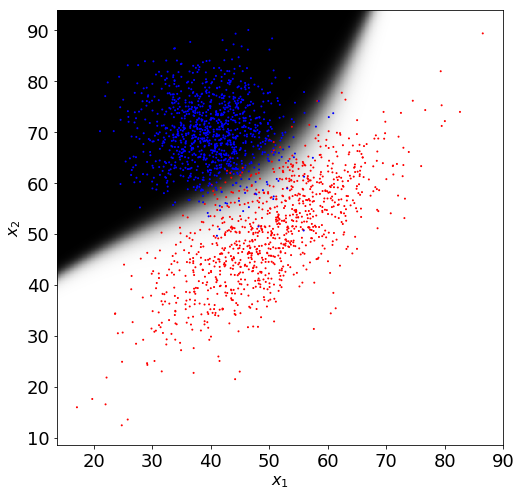

In [ ]:
def x_extend(x):
    #return np.c_[np.ones(len(x)), x]
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2] # kvadratickĂĄ expanze
    return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2, x[:,0]**2*x[:,1], x[:,0]*x[:,1]**2, x**3] # kubickĂĄ expanze

lmbd=len(x)*0.1 #Regularizacni koeficient, lmbd=0.0 => bez regularizace


x = x_extend(np.r_[xr, xb]) #data rizĹĄĂ­Ĺime o jednicku jako "nultĂ˝" koeficient 
t = np.r_[np.ones(len(xr)), np.zeros(len(xb))]
w = np.zeros_like(x[0]) # "nultĂ˝" koeficient je w0
y = logistic_sigmoid(x.dot(w))
xenropy_last = np.sum(-t*np.log(y) - (1-t)*np.log(1-y)) + lmbd*np.sum(w[1:]**2) 
xentropy=[xenropy_last]

#Matice s lmbd na diagonĂĄle pro regularizaci Hessianu. lmbdI[0,0]=0.0 abychom neregularizovali w_0
lmbdI = np.diag(np.r_[0, [lmbd]*len(w[1:])])
for i in range(50):
    w_old = w
    r = y * (1 - y)
    lmbdW = lmbd*np.r_[0, w[1:]] # lmbd*w, kde nultĂ˝ koeficient je 0, abychom neregularizovali w0   
    w = w - ((y - t).dot(x)+lmbdW).dot(np.linalg.inv(lmbdI+(x.T * r).dot(x))) # Newton-Raphson update

    while True: # Budeme pĹŻlit krok dokud se nezlepĹĄĂ­ objectivnĂ­ funkce.
      y = logistic_sigmoid(x.dot(w))
      xenropy_new = np.sum(-t*np.log(y) - (1-t)*np.log(1-y)) + lmbd*np.sum(w[1:]**2)
      if xenropy_last >= xenropy_new:
        break
      w = (w+w_old)*0.5
    xenropy_last = xenropy_new
    xentropy.append(xenropy_last)

    clear_output(wait=True)
    plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
    plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
    plt.show()
plt.plot(xentropy)